# **IMAGE CLASSIFICATION – FASHION MNIST**

### *Mini Project 1*


*Name: Gaurika Chopra*  
*Date: 29.10.2025*

Cloning the Fashion-MNIST Repository

In this step, I am cloning a GitHub repository named **`fashion-mnist`**.

Cloning means downloading all the files and version history from a remote Git repository to the local computer.  
The command below creates a new folder called **`fashion-mnist`** and copies the entire project into it.


In [1]:
# !git clone https://github.com/zalandoresearch/fashion-mnist.git

The dataset files in the `fashion-mnist` repository are stored in compressed `.gz` format.  
Before using them, I extract them.

The command below `gzip` to decompress all `.gz` files in the `fashion-mnist/data/fashion/` folder.

In [2]:
#!gzip -d fashion-mnist/data/fashion/*.gz

Importing Required Libraries

In this step, I import all the essential Python libraries needed for working with the **Fashion-MNIST dataset** and building a **neural network** using **PyTorch**.

In [3]:
## Import the necessary libraries 
import numpy as np
import struct
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision

Loading the Fashion-MNIST Dataset from Raw Files

The following two functions are used to **read and process** the raw Fashion-MNIST data files, which are stored in binary `.idx` format.


In [4]:
def load_mnist_images(filename):
    # Open the image file in binary read mode
    with open(filename, 'rb') as f:
        # Read the first 16 bytes which contain header information
        magic, num, rows, cols = struct.unpack(">IIII", f.read(16))
        # Read the rest of the file as unsigned 8-bit integers (pixel values 0–255)
        data = np.frombuffer(f.read(), dtype=np.uint8)
        # Reshape the flat array into a 4D array
        data = data.reshape(num, 1, rows, cols)
        return data / 255.0  # normalize to [0,1] for NN input

def load_mnist_labels(filename):
    # Open the label file in binary read mode
    with open(filename, 'rb') as f:
        # Read the first 8 bytes which contain header information
        magic, num = struct.unpack(">II", f.read(8))
        # Read the remaining bytes as unsigned 8-bit integers (label values 0–9)
        data = np.frombuffer(f.read(), dtype=np.uint8)
        # Return the 1D array of labels
        return data

Loading the Training and Test Datasets

Using helper functions to read the Fashion-MNIST files, I use them to load both the **training** and **test** datasets.

In [5]:
train_images = load_mnist_images('fashion-mnist/data/fashion/train-images-idx3-ubyte')
train_labels = load_mnist_labels('fashion-mnist/data/fashion/train-labels-idx1-ubyte')
test_images  = load_mnist_images('fashion-mnist/data/fashion/t10k-images-idx3-ubyte')
test_labels  = load_mnist_labels('fashion-mnist/data/fashion/t10k-labels-idx1-ubyte')

In [6]:
print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

(60000, 1, 28, 28) (60000,)
(10000, 1, 28, 28) (10000,)


Creating PyTorch Datasets and Data Loaders

Now that the Fashion-MNIST images and labels are loaded as NumPy arrays, I convert them into PyTorch tensors and wrap them in `TensorDataset` and `DataLoader` objects.  
It makes it easy to feed data into the NN for training and testing.


In [7]:
train_dataset = TensorDataset(
    torch.tensor(train_images, dtype=torch.float32),
    torch.tensor(train_labels, dtype=torch.long)
)

test_dataset = TensorDataset(
    torch.tensor(test_images, dtype=torch.float32),
    torch.tensor(test_labels, dtype=torch.long)
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

Training images


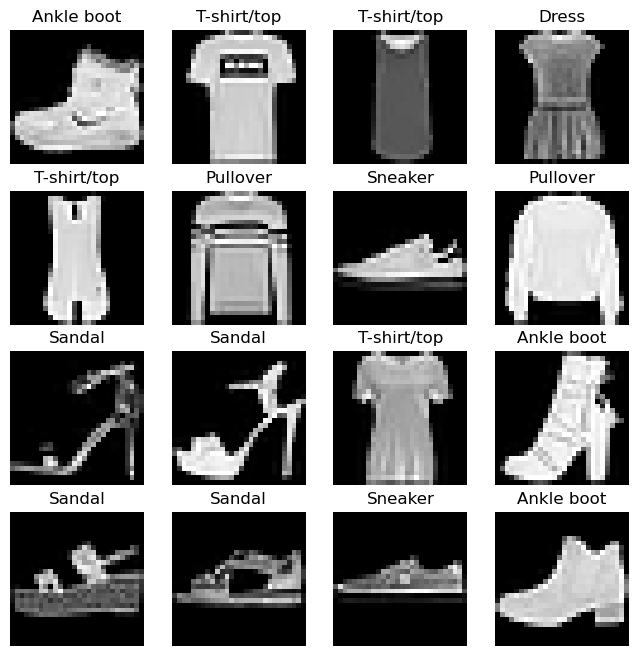

Testing images


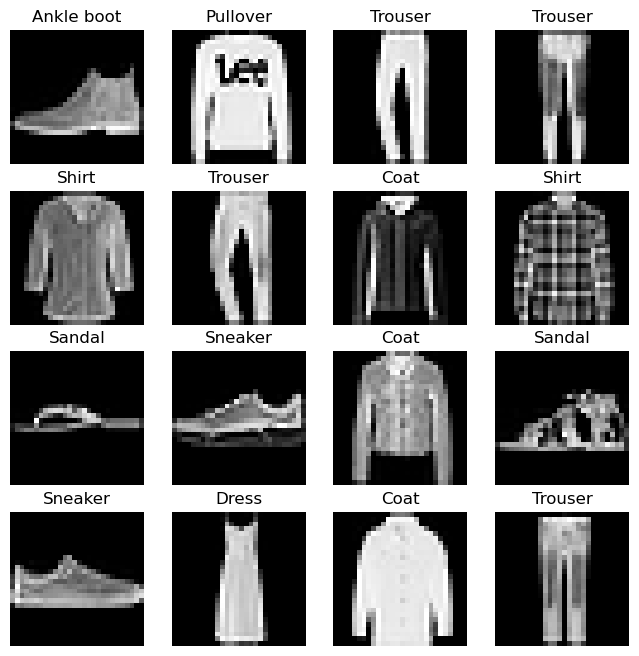

In [9]:
def show_images(images, labels, classes, n=16):
    plt.figure(figsize=(8,8))
    for i in range(n):
        plt.subplot(4,4,i+1)
        plt.imshow(images[i][0], cmap='gray')
        plt.title(classes[labels[i]])
        plt.axis('off')
    plt.show()

classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# training images
print("Training images")
show_images(train_images, train_labels, classes, n=16)

# test images
print("Testing images")
show_images(test_images, test_labels, classes, n=16)

The `FashionCNN` class below defines a **CNN** I built with PyTorch for classifying images in the **Fashion-MNIST dataset**.  
Fashion-MNIST has 28×28 grayscale images of clothing items with a goal  to predict which of the 10 categories each image belongs to.

The network has 2 parts:

`conv_layers`, automatically learns to extract features from the raw pixel data.

- It starts with 2 blocks, each made up of:
  - `Conv2d` layers: To learn spatial patterns like edges, textures, and shapes.
  - `BatchNorm2d` layers: To normalize activations to stabilize and speed up training.
  - `ReLU` activations: To add non-linearity so the model can learn complex relationships.
  - `MaxPool2d` layers: To help the model focus on the most important features

Each image is transformed into **64 feature maps of size 7×7**, representing learned visual features.

`fc_layers`, takes the extracted features to further perform classification.

- The `Flatten` layer converts 3D feature maps to a 1D vector.
- fully connected (`Linear`) layer reduces this to 128 neurons.
- `ReLU` activation adds non-linearity.
- `Dropout` layer randomly disables 30% (0.3) of neurons during training to prevent overfitting.
- `Linear` layer outputs **10 values**, each representing one clothing class.

In [10]:
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [11]:
model = FashionCNN() #Initializing the CNN Model

In [12]:
criterion = nn.CrossEntropyLoss() #Loss function for training
optimizer = optim.Adam(model.parameters(), lr=0.001) #optimizer to update model weights

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #Device setup, Checks if GPU (CUDA) is available otherwise uses the CPU
model.to(device)

num_epochs = 10 # No of times model iterates over the entire training dataset
train_losses = []
train_accuracies = []
# Stores loss and accuracy after each epoch for monitoring training progress

for epoch in range(num_epochs): #Looping through all epochs
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad() # Clears gradients from previous step
        outputs = model(images) #Forward pass through CNN to get predicted logits
        loss = criterion(outputs, labels) #Computes loss between predictions and true labels
        loss.backward()
        optimizer.step()

        running_loss += loss.item() #Converts tensor loss to a Python float for logging
        _, predicted = torch.max(outputs.data, 1) #Gets predicted class indices for the batch
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Computes average loss and accuracy for the entire epoch 
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

Epoch [1/10], Loss: 0.4380, Accuracy: 84.11%
Epoch [2/10], Loss: 0.3006, Accuracy: 89.13%
Epoch [3/10], Loss: 0.2636, Accuracy: 90.36%
Epoch [4/10], Loss: 0.2337, Accuracy: 91.47%
Epoch [5/10], Loss: 0.2161, Accuracy: 92.11%
Epoch [6/10], Loss: 0.1967, Accuracy: 92.66%
Epoch [7/10], Loss: 0.1779, Accuracy: 93.34%
Epoch [8/10], Loss: 0.1662, Accuracy: 93.78%
Epoch [9/10], Loss: 0.1551, Accuracy: 94.15%
Epoch [10/10], Loss: 0.1439, Accuracy: 94.51%


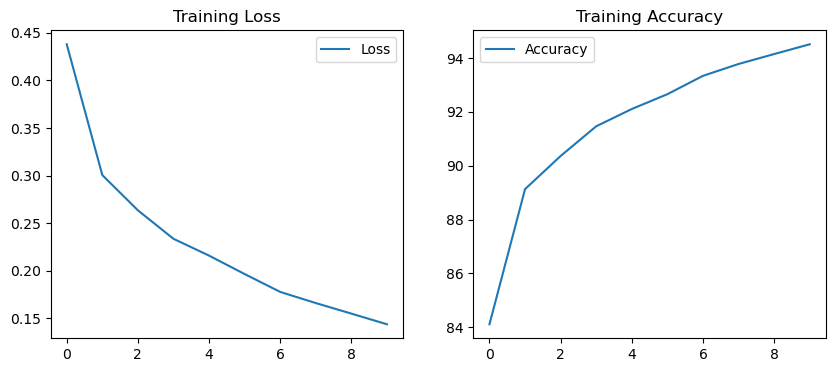

In [14]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.show()

In [15]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 92.11%


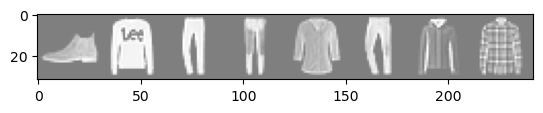

Predicted: Ankle boot Pullover   Trouser    Trouser    Shirt      Trouser    Coat       Shirt     
Actual:    Ankle boot Pullover   Trouser    Trouser    Shirt      Trouser    Coat       Shirt     


In [16]:
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

def imshow(img):
    img = img / 2 + 0.5     # unnormalize if needed
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, preds = torch.max(outputs, 1)

imshow(torchvision.utils.make_grid(images[:8].cpu()))
print('Predicted:', ' '.join(f'{classes[preds[j]]:10s}' for j in range(8)))
print('Actual:   ', ' '.join(f'{classes[labels[j]]:10s}' for j in range(8)))
